In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from workbench.utils import get_type_a_uncertainty, get_type_b_uncertainty, get_expanded_uncertainty, format_timedelta
from workbench.utils import get_type_b_uncertainties, get_expanded_uncertainties

test_data = np.genfromtxt("test-data.csv", delimiter=",", skip_header=1, dtype=[
    ('timestamp', 'datetime64[ms]'),
    ('voltage', 'float64'),
    ('system_temperature', 'float64'),
])

In [6]:
from workbench.utils import format_voltage

pd.DataFrame([
    ["Sample size", len(test_data)],
    ["Start", test_data["timestamp"].min()],
    ["End", test_data["timestamp"].max()],
    ["Duration", format_timedelta(test_data["timestamp"][-1] - test_data["timestamp"][0])],
    ["Min", format_voltage(test_data["voltage"].min(), precision=7)],
    ["Max", format_voltage(test_data["voltage"].max(), precision=7)],
    ["Mean", format_voltage(test_data["voltage"].mean(), precision=7)],
    ["Sample standard deviation", format_voltage(test_data["voltage"].std(ddof=1))],
], columns=["", "Measurements"])

,,Measurements
0,Sample size,5259
1,Start,2024-12-24T00:00:01.686
2,End,2024-12-24T05:59:59.253
3,Duration,"0 days, 5 hours, 59 minutes"
4,Min,4.9981939 V
5,Max,4.9981985 V
6,Mean,4.9981962 V
7,Sample standard deviation,642.2 nV


In [7]:
type_a_uncertainty = get_type_a_uncertainty(test_data["voltage"])
expanded_type_b_uncertainties = abs(test_data["voltage"]) * 50e-6 + 10 * 5e-6
type_b_uncertainty = get_type_b_uncertainty(expanded_type_b_uncertainties, k=2)
expanded_uncertainty = get_expanded_uncertainty(type_a_uncertainty, type_b_uncertainty, k=2)

pd.DataFrame([
    ["Mean", format_voltage(test_data["voltage"].mean(), precision=7)],
    ["Type A uncertainty (standard error of mean)", format_voltage(type_a_uncertainty)],
    ["Type B uncertainty (Keysight 34461A, 10 V, 2-year spec)", format_voltage(type_b_uncertainty)],
    ["Expanded uncertainty (k=2)", format_voltage(expanded_uncertainty)],
], columns=["", "Voltage"])

,,Voltage
0,Mean,4.9981962 V
1,Type A uncertainty (standard error of mean),8.9 nV
2,"Type B uncertainty (Keysight 34461A, 10 V, 2-y...",150.0 µV
3,Expanded uncertainty (k=2),299.9 µV


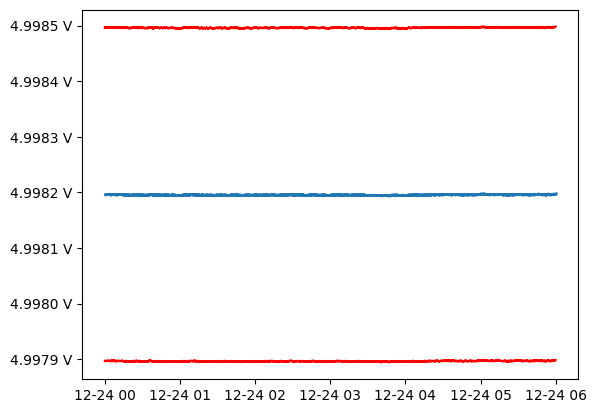

In [8]:
from matplotlib.ticker import FuncFormatter

fig, ax1 = plt.subplots()

type_a_uncertainty = get_type_a_uncertainty(test_data["voltage"])
expanded_type_b_uncertainties = abs(test_data["voltage"]) * 50e-6 + 10 * 5e-6
type_b_uncertainties = get_type_b_uncertainties(expanded_type_b_uncertainties, k=2)
expanded_uncertainties = get_expanded_uncertainties(type_a_uncertainty, type_b_uncertainty, k=2)

ax1.yaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: format_voltage(x, precision=4)))
ax1.scatter(test_data["timestamp"], test_data["voltage"], s=0.2)

ax1.plot(test_data["timestamp"], test_data["voltage"] - expanded_uncertainties, color="red", label=f"Expanded uncertainty")
ax1.plot(test_data["timestamp"], test_data["voltage"] + expanded_uncertainties, color="red")

plt.show()